In [10]:
import numpy as np
import pandas as pd
import struct
import matplotlib.pyplot as plt

In [17]:
def leer_gadget2_por_tipo(path_del_archivo):
    with open(path_del_archivo, "rb") as f:
        # Leer header
        f.seek(0)
        _ = struct.unpack("I", f.read(4))[0]
        header_bytes = f.read(256)
        _ = struct.unpack("I", f.read(4))[0]

        # numero_de_particulas = número de partículas por tipo_de_particula
        numero_de_particulas = struct.unpack("6I", header_bytes[0:24])
        masas_del_header = struct.unpack("6d", header_bytes[24:72])  # masas por tipo_de_particula si son iguales
        total_de_particulas = sum(numero_de_particulas)

        tipos_presentes = [i for i, n in enumerate(numero_de_particulas) if n > 0]

        print(f"Tipos presentes: total de particulas\n {list(zip(tipos_presentes,numero_de_particulas))}")
        print(f"Total de partículas: {total_de_particulas:,}")

        # Leer POS
        _ = struct.unpack("I", f.read(4))[0]
        posiciones = np.fromfile(f, dtype=np.float32, count=total_de_particulas * 3).reshape((total_de_particulas, 3))
        _ = struct.unpack("I", f.read(4))[0]

        # Leer VEL
        _ = struct.unpack("I", f.read(4))[0]
        velocidades = np.fromfile(f, dtype=np.float32, count=total_de_particulas * 3).reshape((total_de_particulas, 3))
        _ = struct.unpack("I", f.read(4))[0]

        # Leer IDs
        _ = struct.unpack("I", f.read(4))[0]
        ids = np.fromfile(f, dtype=np.uint32, count=total_de_particulas)
        _ = struct.unpack("I", f.read(4))[0]

        # Leer masas si hay (algunas simulaciones lo hacen)
        masas = None

        try:
            _ = struct.unpack("I", f.read(4))[0]
            masas = np.fromfile(f, dtype=np.float32, count=total_de_particulas)
            _ = struct.unpack("I", f.read(4))[0]

        except:
         masas = None

    # Separar los datos por tipo_de_particula de partícula
    bases_de_datos_por_tipo = {}
    offset = 0

    for tipo_de_particula, cantidad_de_particulas in enumerate(numero_de_particulas):
        
        if cantidad_de_particulas == 0:
            continue

        # Obtener fragmentos por tipo_de_particula
        posicion = posiciones[offset : offset + cantidad_de_particulas]
        velocidad = velocidades[offset : offset + cantidad_de_particulas]
        id = ids[offset : offset + cantidad_de_particulas]

        if masas is not None:
            masa = masas[offset : offset + cantidad_de_particulas]

        elif masas_del_header[tipo_de_particula] != 0:
            masa = np.full(cantidad_de_particulas, masas_del_header[tipo_de_particula])
            
        else:
            masa = None

        informacion_galaxia = {
            "id": id,
            "x": posicion[:, 0],
            "y": posicion[:, 1],
            "z": posicion[:, 2],
            "v_x": velocidad[:, 0],
            "v_y": velocidad[:, 1],
            "v_z": velocidad[:, 2],
        }

        if masa is not None:
            informacion_galaxia["masa"] = masa

        componente_df = pd.DataFrame(informacion_galaxia)
        bases_de_datos_por_tipo[str(tipo_de_particula)] = componente_df

        offset += cantidad_de_particulas

    return bases_de_datos_por_tipo

# Uso
archivo = r"Archivos\AM2229-735_host_RL_050"
dfs = leer_gadget2_por_tipo(archivo)

materia_oscura_df = dfs['1']
disco_df = dfs['2']
bulbo_df = dfs['3']


Tipos presentes: total de particulas
 [(1, 0), (2, 2339761), (3, 1396500)]
Total de partículas: 4,334,761


In [18]:
def centrar_galaxia(base_de_datos):
    
    masa_total_galaxia = base_de_datos.masa.sum()

    x_cm = base_de_datos.masa @ base_de_datos.x / masa_total_galaxia
    y_cm = base_de_datos.masa @ base_de_datos.y / masa_total_galaxia
    z_cm = base_de_datos.masa @ base_de_datos.z / masa_total_galaxia

    base_de_datos['x0'] = base_de_datos.x - x_cm
    base_de_datos['y0'] = base_de_datos.y - y_cm
    base_de_datos['z0'] = base_de_datos.z - z_cm

centrar_galaxia(materia_oscura_df)
centrar_galaxia(disco_df)
centrar_galaxia(bulbo_df)

In [19]:
def rotar_galaxia(base_de_datos):
    lx = (base_de_datos.x @ base_de_datos.v_z) - (base_de_datos.z @ base_de_datos.v_y)
    ly = (base_de_datos.z @ base_de_datos.v_x) - (base_de_datos.x @ base_de_datos.v_z)
    lz = (base_de_datos.x @ base_de_datos.v_y) - (base_de_datos.y @ base_de_datos.v_x)

    magnitud_l = np.linalg.norm([lx, ly, lz])

    angulo_z = - np.atan(ly / lx)
    angulo_y = np.acos(lz / magnitud_l)
     
    cos_z = np.cos(angulo_z)
    sin_z = np.sin(angulo_z)
    cos_y = np.cos(angulo_y)
    sin_y = np.sin(angulo_y)

    base_de_datos['x_f'] = (
    base_de_datos.x0 * (cos_z * cos_y) + 
    base_de_datos.y0 * (- sin_z) +
    base_de_datos.z0 * (cos_z * sin_y)
    )
    
    base_de_datos['y_f'] = (
        base_de_datos.x0 * (sin_z * cos_y) + 
        base_de_datos.y0 * (cos_z) +
        base_de_datos.z0 * (sin_z * sin_y)
        )

    base_de_datos['z_f'] = (
        base_de_datos.x0 * (- sin_y) + 
        base_de_datos.z0 * (cos_y)
        )

rotar_galaxia(materia_oscura_df)
rotar_galaxia(disco_df)
rotar_galaxia(bulbo_df)

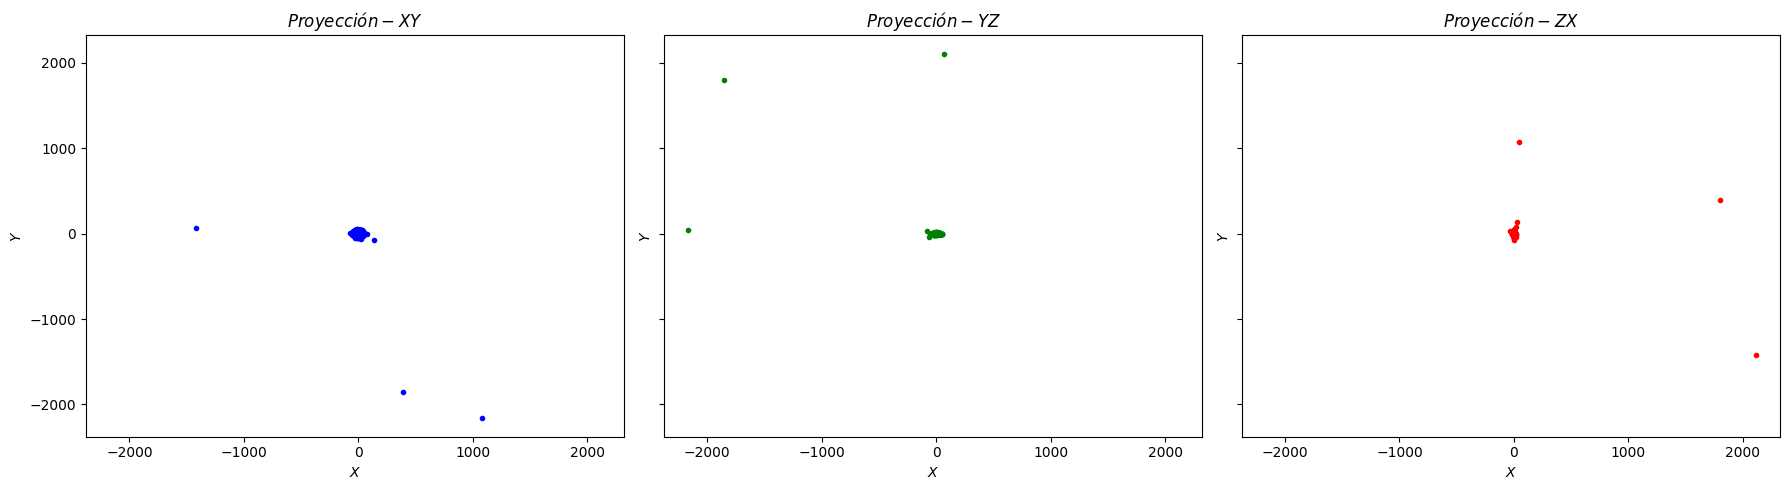

In [16]:
def graficar_proyecciones(base_de_datos, x, y, z):

    # Creamos una figura con 3 subplots en una sola fila (1 fila, 3 columnas)
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)  # Ancho x alto en pulgadas

    # Primer gráfico: masa vs radio
    axs[0].scatter(base_de_datos[x], base_de_datos[y], color='blue', marker= '.')
    axs[0].set_title(r'$Proyección-XY$')
    axs[0].set_xlabel(r'$X$')
    axs[0].set_ylabel(r'$Y$')

    # Segundo gráfico
    axs[1].scatter(base_de_datos[y], base_de_datos[z], color='green', marker= '.')
    axs[1].set_title(r'$Proyección-YZ$')
    axs[1].set_xlabel(r'$X$')
    axs[1].set_ylabel(r'$Y$')

    # Tercer gráfico
    axs[2].scatter(base_de_datos[z], base_de_datos[x], color='red', marker= '.')
    axs[2].set_title(r'$Proyección-ZX$')
    axs[2].set_xlabel(r'$X$')
    axs[2].set_ylabel(r'$Y$')

    # Ajustar los espacios entre los subplots para evitar superposición
    plt.tight_layout()
    plt.show()

graficar_proyecciones(disco_df, 'x0', 'y0', 'z0')
